<h1>Prédiction de la valuer d'ouverture du TunIndex à partir KPP</h1>
    <p>on Aura recours à la variante de regression de l'algorithme de classification des k-plus proches voisins, afian de prédire la valeur d'ouverture du tun*index
   <img src='KNNregression.png'></p>

In [1]:
import pandas as pd
import numpy as np 
import math
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from statistics import *


In [2]:
#Definition de la variable de prediction (X)
data = pd.read_csv('Data.csv')
data.set_index(["Unnamed: 0.1"], inplace=True)
ti = pd.DataFrame(index = data.index)
ti["Open-Close"] = data["Open"] - data["Price"]
ti["High-Low "] = data["High"] - data["Low"] 
#definition La variablle cible (Y)
tto = np.where(data["Price"].shift(-1)>data["Price"],1,-1)

In [3]:
#decoupage du dataset en train et test set
split_percentage = 0.7
split = int(split_percentage*len(data))

X_train = ti[:split]
Y_train = tto[:split]

X_test = ti[split:]
Y_test = tto[split:]

In [4]:
#instancier le model KPP
knn= KNeighborsClassifier(n_neighbors=2)

# fit the model
fitted_model = knn.fit(X_train, Y_train)
predictions = fitted_model.predict(X_test)



In [5]:
#matrice de confusion
print(confusion_matrix(Y_test, predictions))

[[71 22]
 [87 40]]


In [6]:
presision_train = accuracy_score(Y_train, knn.predict(X_train))
presision_test = accuracy_score(Y_test, knn.predict(X_test))
print ('Train data Accuracy: %.2f' %presision_train)
print ('Test data Accuracy: %.2f' %presision_test)

Train data Accuracy: 0.78
Test data Accuracy: 0.50


In [7]:
#prediction
ti.dropna()
ti['Predicted_Signal'] = knn.predict(ti)
ti.dropna()
#calcul et analyse de la stratégie de prédiction
ti["retour du tunindx"] = np.log(data["Price"]/data["Price"].shift(1))
retour_cumulée_tunindex = ti[split:]["retour du tunindx"].cumsum()*100

ti["retour stratégie"] = ti["retour du tunindx"] * ti['Predicted_Signal'].shift(1)
retour_cummulé_stratégie =   ti[split:]["retour stratégie"].cumsum()*100
ti

,Open-Close,High-Low,Predicted_Signal,retour du tunindx,retour stratégie
Unnamed: 0.1,,,,,
2018-01-02,83.99,111.31,-1,NaN,NaN
2018-01-03,-65.63,66.68,-1,0.008651,-0.008651
2018-01-04,9.08,51.91,-1,-0.001318,0.001318
2018-01-05,-24.44,38.91,1,0.002573,-0.002573
2018-01-08,-44.77,61.71,-1,0.007129,0.007129
...,...,...,...,...,...
2020-12-07,-24.92,44.27,1,0.003898,-0.003898
2020-12-08,-15.51,45.65,-1,0.002571,0.002571
2020-12-09,-18.45,43.47,1,0.002919,-0.002919


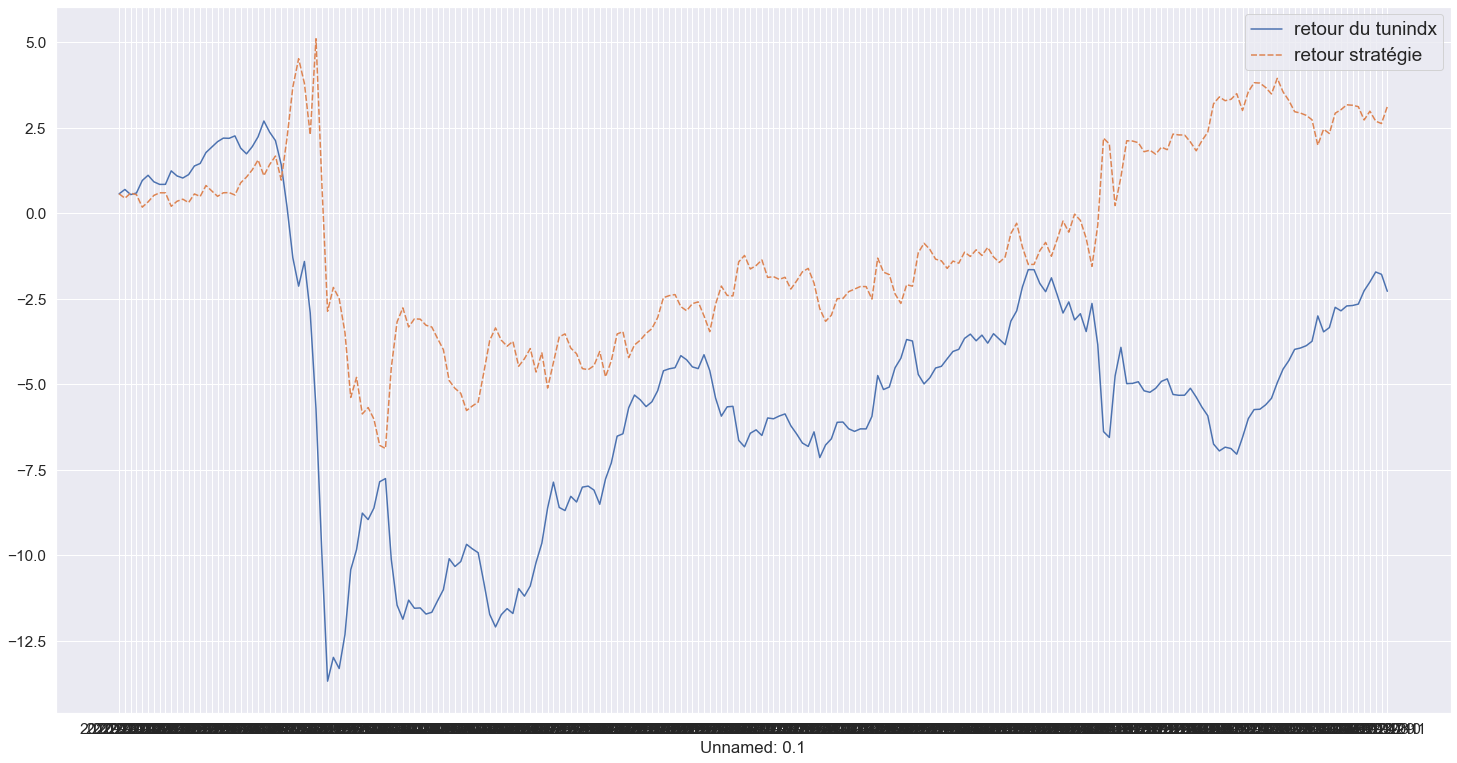

In [8]:
#Plotting
newdf = pd.concat([retour_cumulée_tunindex, retour_cummulé_stratégie], axis=1)  
#Graph plotting
  
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)


In [9]:
#recherche de la valeur de K la plus optimale 
diff_sumul= []
k_range = range(1,100)
topred = pd.DataFrame(index = ti.index)
topred = pd.concat([ti['Open-Close'], ti[ 'High-Low ']], axis=1)
for k in k_range:
    ti.dropna()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    ti[f'Predicted_Signal{k}'] = knn.predict(topred)
    ti[f"retour du tunindx{k}"] = np.log(data["Price"]/data["Price"].shift(1))
    retour_cumulée_tunindex = ti[split:][f"retour du tunindx{k}"].cumsum()*100
    ti[f"retour stratégie{k}"] = - ti[f"retour du tunindx{k}"] * ti[f'Predicted_Signal{k}'].shift(1)
    retour_cummulé_stratégie =  - ti[split:][f"retour stratégie{k}"].cumsum()*100
    diff_sumul.append(mean(int(x - y) for x, y in zip(retour_cummulé_stratégie, retour_cumulée_tunindex)))


(array([ 0.,  5., 10., 15., 20., 25., 30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

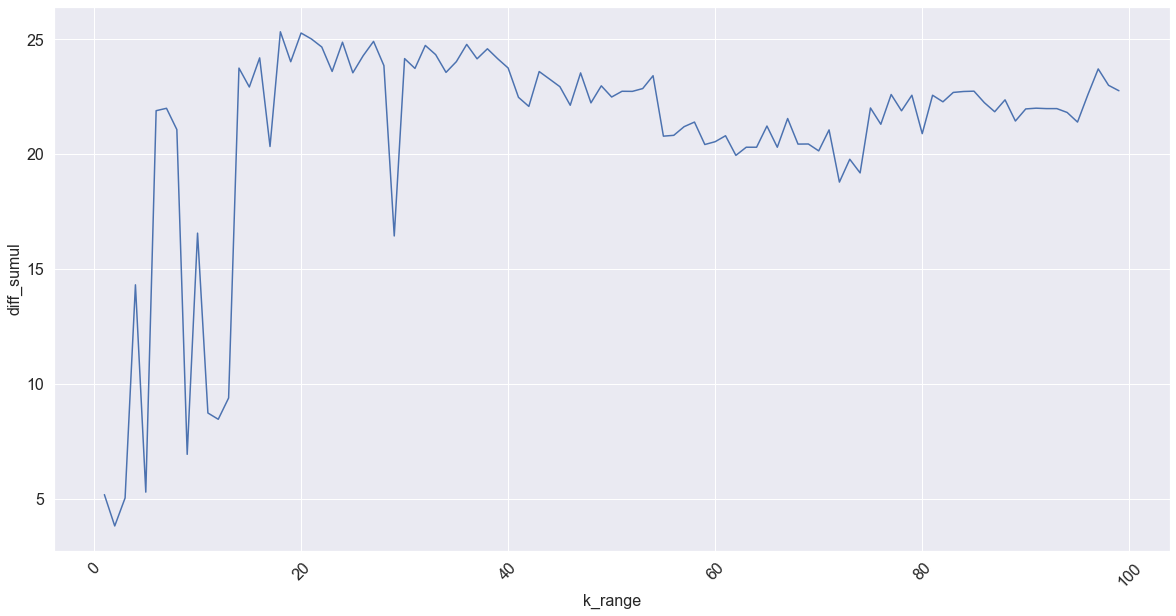

In [10]:
plt.figure(figsize=(20,10))
plt.plot(k_range, diff_sumul)
plt.xlabel('k_range', fontsize=16)
plt.ylabel('diff_sumul', fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)

<h3>Conclusion</h3>
<p>La meilleur valeur de k (minimisant 'diff_sumul') est celli qui la plus petite que possible car aucune des valuers de k met duff_sumul à zero</p>